## Dynamic Programming

In this presentation, we focus on solving dynamic consumption/saving problem.  
A general description of problem is like this:  
$$
V(s_t)=max_{x_t}\ \{u(s_t, x_t)+\beta E_{t+1}V(s_{t+1})\}
$$
where $s_t$ is state variables, and $x_t$ is control variable, $V$ and $u$ is the value function and utility function.  
In particular, the problem in [example](http://lectures.quantecon.org/py/optgrowth.html#id15) can be described as:  
$$
V(k_t)=max_{0\leq c_t\leq f(k_t)}\ \{u(c_t)+\beta E_{t+1}V(k_{t+1})\}
$$
where $f(k_t)=k_t^{\alpha}$ and $k_{t+1}=f(k_t)-c_t$.
An analytic solution for this problem by guessing the functional form of value function is:  
$$
V^{*}(k_t)=c_1 + c_2 log(k_t)
$$
Where $c_1$ and $c_2$ are some constants. Later I will use this true solution to check the fittness of different methods.  
  


We can also derive Euler Equation from the previous problem:  
$$
u'(c_t)=\beta E_{t+1} \{f_{k}(k_{t+1})u'(c_{t+1})\}
$$
We can use this relationship to do policy function iteration.

The traditional way to do policy function iteration involves finding roots, which is very computation comsumption intensive. Thus we introduce the Endogenous Grid Points method.  
(see the general description of problem in ZICE2014)  
Thus, the previous problem can be rewritten to be as:  
$$
V(M_t)=max_{0\leq c_t\leq M_t}\ \{u(c_t)+\beta E_{t+1}V(M_{t+1}(M_t-c_t))\}
$$
where $M_t=f(k_t)$ is the output, and thus all the money people can consume at time t.  
the Euler Equation is like:  
$$
u'(c_t)=\beta E_{t+1} \{f_{k}(M_{t}-c_t)u'(c_{t+1}(M_{t+1}))\}
$$
Given the policy function $c_{t+1}(M_{t+1})$ and the current resources $M_t$, we can solve $c_t$ analytically with little computation consumption.  
The procedure will be described in detail later.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import quantecon as qe
from scipy import interpolate
from numpy import log
from scipy.optimize import fminbound
from scipy import interp

In [3]:
# Primitives and grid
alpha = 0.65
beta = 0.95
grid_max = 2
grid_size = 150
grid = np.linspace(1e-6, grid_max, grid_size)
# Exact solution
ab = alpha * beta
c1 = (log(1 - ab) + log(ab) * ab / (1 - ab)) / (1 - beta)
c2 = alpha / (1 - ab)


def v_star(k):
    return c1 + c2 * log(k)


def bellman_operator(w):
    """
    The approximate Bellman operator, which computes and returns the updated
    value function Tw on the grid points.

        * w is a flat NumPy array with len(w) = len(grid)

    The vector w represents the value of the input function on the grid
    points.
    """
    # === Apply linear interpolation to w === #
    Aw = lambda x: interp(x, grid, w)

    # === set Tw[i] equal to max_c { log(c) + beta w(f(k_i) - c)} === #
    Tw = np.empty(grid_size)
    for i, k in enumerate(grid):
        objective = lambda c: - log(c) - beta * Aw(k**alpha - c)
        c_star = fminbound(objective, 1e-6, k**alpha)
        Tw[i] = - objective(c_star)
    return Tw

In [4]:
def compute_greedy(w):
    Aw = lambda x: interp(x, grid, w) 

    sigma = np.empty(grid_size)
    for i, k in enumerate(grid):
        objective = lambda c: - log(c) - beta * Aw(k**alpha - c)
        sigma[i] = fminbound(objective, 1e-6, k**alpha)
    return sigma

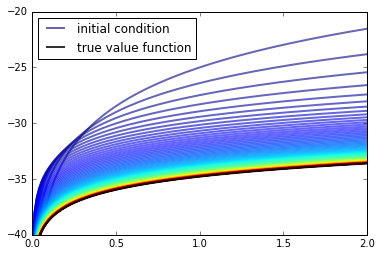

In [5]:
w = 5 * log(grid) - 25  # An initial condition -- fairly arbitrary
n = 100
fig, ax = plt.subplots()
ax.set_ylim(-40, -20)
ax.set_xlim(np.min(grid), np.max(grid))
lb = 'initial condition'
ax.plot(grid, w, color=plt.cm.jet(0), lw=2, alpha=0.6, label=lb)
for i in range(n):
    w = bellman_operator(w)
    ax.plot(grid, w, color=plt.cm.jet(i / n), lw=2, alpha=0.6)
lb = 'true value function'
ax.plot(grid, v_star(grid), 'k-', lw=2, alpha=0.8, label=lb)
ax.legend(loc='upper left')

plt.show()


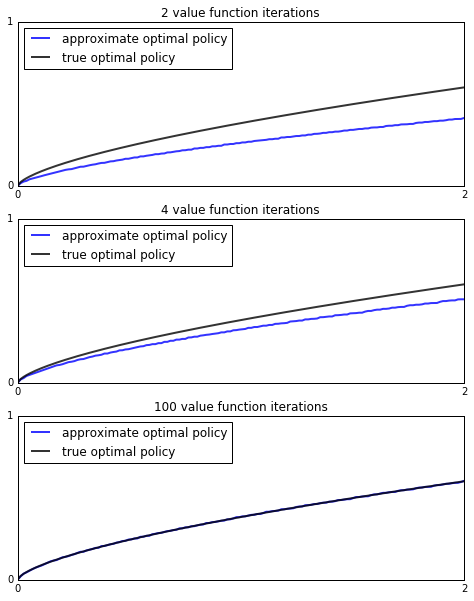

In [6]:
alpha, beta = 0.65, 0.95
true_sigma = (1 - alpha * beta) * grid**alpha

fig, ax = plt.subplots(3, 1, figsize=(8, 10))

for i, n in enumerate((2, 4, 100)):
    ax[i].set_ylim(0, 1)
    ax[i].set_xlim(0, 2)
    ax[i].set_yticks((0, 1))
    ax[i].set_xticks((0, 2))

    w = 5 * log(grid) - 25  # Initial condition
    v_stars = qe.compute_fixed_point(bellman_operator, w, 
                                 max_iter=n, 
                                 verbose=0)
    sigma = compute_greedy(v_stars)

    ax[i].plot(grid, sigma, 'b-', lw=2, alpha=0.8, label='approximate optimal policy')
    ax[i].plot(grid, true_sigma, 'k-', lw=2, alpha=0.8, label='true optimal policy')
    ax[i].legend(loc='upper left')
    ax[i].set_title('{} value function iterations'.format(n))
    

In [7]:
true_sigma = (1 - alpha * beta) * grid**alpha
np.max(np.abs(sigma - true_sigma))

0.0045626822849907378

The policy function iteration follows as 
$$
u'(c_t) = \beta f_{k}(k_t) E_{t}(u'(c_{t+1}))  
$$
$$
\Rightarrow (1/c_t) = \beta \alpha k^{\alpha-1} E_{t}(1/c_{t+1})
$$

In [8]:
def euler_operator(c_pre, grid):
    """
    The approximate Euler operator, which computes and returns the updated
    value function Ec on the grid points.

        * c is a flat NumPy array with len(w) = len(grid)

    The vector c represents the optimal consumption given capital.
    """
    # === Apply linear interpolation to c === #
    Ac = interpolate.UnivariateSpline(grid, c_pre, k=1, s=0)


    # === set Ec[i] equal to u'(c) =  === #
    Ec = np.empty(grid_size)
    for i, k in enumerate(grid):
        #define the capital motion law
        def k_(c):
            return k**(alpha) - c
        objective = lambda c: np.abs((Ac(k_(c)))/(beta*alpha*(k_(c))**(alpha-1)) - c)
        c_star = fminbound(objective, 1e-6, k**alpha)
        Ec[i] = c_star
    return Ec, grid

In [16]:
def iteration(n, operator, show_pic = False): 
    Kgrid = np.linspace(1e-6, grid_max, grid_size)
    K = np.linspace(1e-6, grid_max, grid_size)
    c = K  # At state T, people will consume all they have
    if show_pic:
        fig, ax = plt.subplots()
        lb = 'true optimal policy function'
        true_sigma = (1 - alpha * beta) * K **alpha
        ax.plot(K, true_sigma, 'k-', lw=2, alpha=0.8, label=lb)
        ax.set_xlim(np.min(K), np.max(K))
        lb = 'optimal policy function at t'
        ax.plot(K, c, color=plt.cm.jet(0), lw=2, alpha=0.6, label=lb)
    for i in range(n):
        c, K = operator(c, K)
        if show_pic:
            ax.plot(K, c, color=plt.cm.jet(i / n), lw=2, alpha=0.6)
    
    if show_pic:
        ax.legend(loc='upper left')
        plt.show()
    return c, K

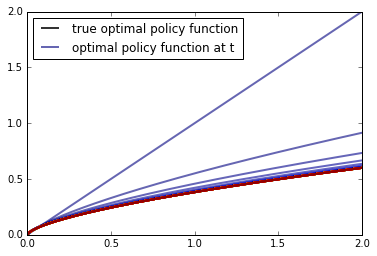

In [18]:
c, K = iteration(100, euler_operator, show_pic = True)

In [19]:
true_sigma = (1 - alpha * beta) * K ** alpha
np.max(np.abs(c - true_sigma))

4.5386303867252231e-05

In [20]:
%timeit iteration(100, euler_operator)

1 loop, best of 3: 9.48 s per loop


1. Choose appropriate guess $A = M_t - c_t$. In this case, we define $M_t$ as output $k^\alpha$, and $A = k_{t+1}$.
2. By $A$, we can compute $M_{t+1}=A^{\alpha}$.
3. Given $M_{t+1}$ and optimal policy in hand, we can compute $c_{t+1}$ by interpolation.
4. Use the Euler equation to analytically compute $c_{t} = c_{t+1} / \beta \alpha A ^{\alpha - 1}$
5. Now we have $M_t = c_t + A$.
6. A little difference from the lecture, I store the policy by grid points of $k_{t}$ to keep the consistency with other iteration methods.

In [30]:
def EGP_operator(c_pre, K_pre):
    """
    The exact Endogenous Grid Point operator, which compute the state K where a guess 
    decision A is optimal.
    
    c_pre is the previous policy c_t+1 at t.
    K_pre is the state grid points K_t+1 at t.

    Note that grid points K will change for each iteration.
    """
    
    Agrid = np.linspace(1e-6, grid_max ** alpha , grid_size)

    # === Apply linear interpolation to w === #
    Ac = interpolate.UnivariateSpline(K_pre, c_pre, k=1, s=0)

    # === set Tw[i] equal to max_c { log(c) + beta w(f(k_i) - c)} === #
    EGPc = []
    K_new = []
    for i, A in enumerate(Agrid):
        k_ = A
        c_ = Ac(k_)
        c_star = (c_)/(beta*alpha*(k_)**(alpha-1))
        k = (k_ + c_star) ** (1/alpha)
        EGPc.append(c_star)
        K_new.append(k)
    EGPc = np.array(EGPc)
    K_new = np.array(K_new)
    return EGPc, K_new

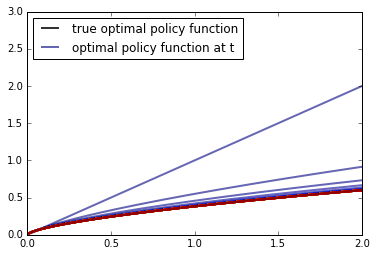

In [34]:
c, K = iteration(100, EGP_operator, show_pic = True)

In [32]:
true_sigma = (1 - alpha * beta) * K ** alpha
np.max(np.abs(c - true_sigma))

3.9923178704048823e-05

In [35]:
%timeit iteration(100, EGP_operator)

1 loop, best of 3: 204 ms per loop


In [37]:
sum(K <= grid_max)

93

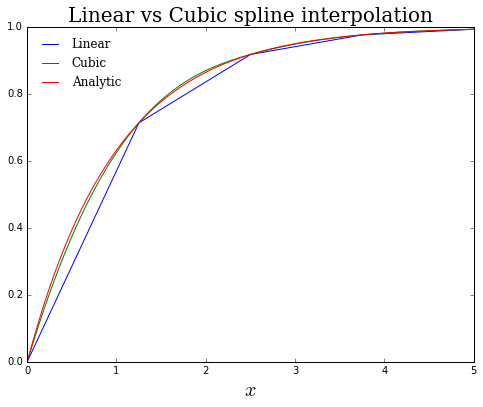

In [38]:
# grid of values to use as interpolation nodes
xgrid = np.linspace(0, 5, 5)

# values of the function we wish to approximate at the interpolation nodes
vals = 1 - np.exp(-xgrid)

# both spline interpolation nests linear interpolation as a special case
linear_interp = interpolate.UnivariateSpline(xgrid, vals, k=1, s=0)
cubic_interp  = interpolate.UnivariateSpline(xgrid, vals, k=3, s=0)

# plot the approximating functions as well as the true function
plt.figure(figsize=(8,6))
plot_grid = np.linspace(0, 5, 1000)
plt.plot(plot_grid, linear_interp(plot_grid), 'b', label='Linear')
plt.plot(plot_grid, cubic_interp(plot_grid), 'g', label='Cubic')
plt.plot(plot_grid, 1 - np.exp(-plot_grid), 'r', label='Analytic')

# axes, labels, title, etc
plt.xlabel('$x$', fontsize=20)
plt.title('Linear vs Cubic spline interpolation', fontsize=20, family='serif')
plt.legend(loc='best', frameon=False, prop={'family':'serif'})

plt.show()

Thus we try cubic interpolation for policy iteration and endogenous grid points method.

In [39]:
def euler_operator_cubic(c_pre, grid):
    """
    The approximate Euler operator, which computes and returns the updated
    value function Ec on the grid points.

        * c is a flat NumPy array with len(w) = len(grid)

    The vector c represents the optimal consumption given capital.
    """
    # === Apply linear interpolation to c === #
    Ac = interpolate.UnivariateSpline(grid, c_pre, k=3, s=0)


    # === set Ec[i] equal to u'(c) =  === #
    Ec = np.empty(grid_size)
    for i, k in enumerate(grid):
        #define the capital motion law
        def k_(c):
            return k**(alpha) - c
        objective = lambda c: np.abs((Ac(k_(c)))/(beta*alpha*(k_(c))**(alpha-1)) - c)
        c_star = fminbound(objective, 1e-6, k**alpha)
        Ec[i] = c_star
    return Ec, grid

def EGP_operator_cubic(c_pre, K_pre):
    """
    The exact Endogenous Grid Point operator, which compute the state K where a guess 
    decision A is optimal.
    
    c_pre is the previous policy c_t+1 at t.
    K_pre is the state grid points K_t+1 at t.

    Note that grid points K will change for each iteration.
    """
    
    Agrid = np.linspace(1e-6, grid_max ** alpha , grid_size)

    # === Apply linear interpolation to w === #
    Ac = interpolate.UnivariateSpline(K_pre, c_pre, k=3, s=0)

    # === set Tw[i] equal to max_c { log(c) + beta w(f(k_i) - c)} === #
    EGPc = []
    K_new = []
    for i, A in enumerate(Agrid):
        k_ = A
        c_ = Ac(k_)
        c_star = (c_)/(beta*alpha*(k_)**(alpha-1))
        k = (k_ + c_star) ** (1/alpha)
        EGPc.append(c_star)
        K_new.append(k)
    EGPc = np.array(EGPc)
    K_new = np.array(K_new)
    return EGPc, K_new

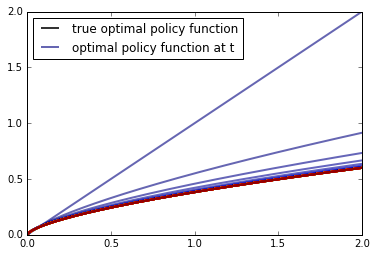

In [40]:
c, K = iteration(100, euler_operator_cubic, show_pic = True)

In [42]:
true_sigma = (1 - alpha * beta) * K ** alpha
np.max(np.abs(c - true_sigma))

2.8932320812969696e-05

In [43]:
%timeit iteration(100, euler_operator_cubic)

1 loop, best of 3: 9.63 s per loop


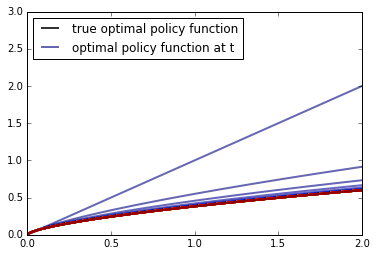

In [44]:
c, K = iteration(100, EGP_operator_cubic, show_pic = True)

In [45]:
true_sigma = (1 - alpha * beta) * K ** alpha
np.max(np.abs(c - true_sigma))

1.538308713422594e-06

In [46]:
%timeit iteration(100, EGP_operator_cubic)

1 loop, best of 3: 192 ms per loop
